In [6]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [13]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [14]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [15]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128

EPOCHS = 5

In [18]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Toatal videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def crop_center(frame):
  cropped = center_crop_layer(frame[None, ...])
  cropped = cropped.numpy().squeeze()
  return cropped

def load_video(path, max_frames = 0):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center(frame)
      frame = frame[:,:,[2,1,0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames)

def build_feature_extractor():
  feature_extractor = keras.applications.DenseNet121(
      weights = 'imagenet',
      include_top = False,
      pooling = "avg",
      input_shape = (IMG_SIZE, IMG_SIZE, 3)
  )
  preprocess_input = keras.applications.densenet.preprocess_input

  inputs = keras.Input((IMG_SIZE,IMG_SIZE,3))

  preprocessed = preprocess_input(inputs)

  outputs = feature_extractor(preprocessed)
  return keras.Model(inputs, outputs, name = 'feature_extractor')

feature_extractor = build_feature_extractor()

label_processor = keras.layers.StringLookup(
    num_oov_indices = 0, vocabulary = np.unique(train_df['tag']), mask_token = None
)

print(label_processor.get_vocabulary())

def prepare_all_videos(df, root_dir):
  num_samples = len(df)
  video_paths = df['video_name'].values.tolist()
  labels = df['tag'].values
  labels = label_processor(labels[...,None]).numpy()

  frame_features = np.zeros(
      shape = (num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype ='float32'
  )

  for idx,path in enumerate(video_paths):
    frames = load_video(os.path.join(root_dir,path))

    if len(frames) < MAX_SEQ_LENGTH:
      diff = MAX_SEQ_LENGTH - len(frames)
      padding = np.zeros((diff, IMG_SIZE,IMG_SIZE,3))
      frames = np.concatenate(frames, padding)

    frames = frames[None,...]

    temp_frame_features = np.zeros(
         shape = (1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype ='float32'
    )

    for i,batch in enumerate(frames):
      video_length = batch.shape[0]
      length = min(MAX_SEQ_LENGTH, video_length)

      for j in range(length):
        if np.mean(batch[j,:] >0.0):
          temp_frame_features[i,j,:] = feature_extractor.predict(
              batch[None,j,:]
          )
        else:
          temp_frame_features[i,j,:] = 0.0
    frame_features[idx,] = temp_frame_features.squeeze()
  return frame_features, labels


Toatal videos for training: 594
Total videos for testing: 224
29084464/29084464 [==============================] - 0s 0us/step
['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Calling prepare_all_videos() on train_df and test_df takes ~20 minutes to complete. For this reason, to save time, here we downloaad already preprocessed Numpy arrays:

In [22]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [23]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


In [29]:
class PositionalEmbedding(layers.Layer):
  def __init__(self,sequence_length, output_dim ,**kwargs):
    super().__init__()
    self.position_embeddings = layers.Embedding(
        input_dim = sequence_length, output_dim = output_dim
    )
    self.sequence_length = sequence_length
    self.otuptu_dim = output_dim

  def call(self,inputs):
    length = tf.shape(inputs)[1]
    positions = tf.range(start = 0, limit = length, delta = 1)
    embedded_positions = self.position_embeddings(positions)
    return inputs + embedded_positions

  def compute_mask(self, inputs, mask =None):
    mask = tf.reduce_any(tf.cast(inputs, 'bool'), axis =-1)
    return mask

In [30]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__()
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = embed_dim, dropout = 0.3
    )

    self.dense_proj = keras.Sequential(
        [layers.Dense(dense_dim, activation = tf.nn.gelu), layers.Dense(embed_dim)]
    )

    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def call(self, inputs, mask =None):
    if mask is not None:
      mask = mask[:,tf.newaxis, :]

    attention_output = self.attention(inputs, inputs, attention_mask = mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input+proj_output)


In [31]:
def get_compiled_model():
  sequence_length = MAX_SEQ_LENGTH
  embed_dim = NUM_FEATURES
  dense_dim = 4
  num_heads = 1
  classes = len(label_processor.get_vocabulary())

  inputs = keras.Input(shape = (None, None))
  x = PositionalEmbedding(
      sequence_length, embed_dim, naem = 'frame_position_embedding'
  )(inputs)

  x = TransformerEncoder(embed_dim, dense_dim, num_heads, name = 'transformer_layer')(x)
  x = layers.GlobalMaxPool1D()(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(classes, activation = 'softmax')(x)
  model = keras.Model(inputs, outputs)

  model.compile(
      optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy']
  )

  return model

In [32]:
def run_experiment():
  filepath = '/tmp/video_classifier'
  checkpoint = keras.callbacks.ModelCheckpoint(
      filepath, save_weights_only = True, save_best_only = True, verbose =1
  )

  model = get_compiled_model()
  history = model.fit(
      train_data,
      train_labels,
      validation_split = 0.15,
      epochs = EPOCHS,
      callbacks = [checkpoint]
  )

  model.load_weights(filepath)
  _,accuracy  = model.evaluate(test_data, test_labels)
  print(f"Test accuracy: {round(accuracy *100, 2)}%")

  return model

In [33]:
trained_model = run_experiment()

Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 1.9102 - accuracy: 0.6329
Epoch 1: val_loss improved from inf to 1.56869, saving model to /tmp/video_classifier
16/16 [==============================] - 11s 508ms/step - loss: 1.9102 - accuracy: 0.6329 - val_loss: 1.5687 - val_accuracy: 0.2333
Epoch 2/5
16/16 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9425
Epoch 2: val_loss improved from 1.56869 to 0.27432, saving model to /tmp/video_classifier
16/16 [==============================] - 10s 641ms/step - loss: 0.1786 - accuracy: 0.9425 - val_loss: 0.2743 - val_accuracy: 0.9222
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9762
Epoch 3: val_loss improved from 0.27432 to 0.21251, saving model to /tmp/video_classifier
16/16 [==============================] - 12s 793ms/step - loss: 0.0624 - accuracy: 0.9762 - val_loss: 0.2125 - val_accuracy: 0.9333
Epoch 4/5
16/16 [==============================] - ETA: 0s 

Test video path: v_Punch_g06_c02.avi
1/1 [==============================] - 0s 42ms/step
Punch: 100.00%
TennisSwing:  0.00%
PlayingCello:  0.00%
ShavingBeard:  0.00%
CricketShot:  0.00%



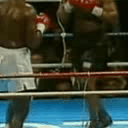

In [39]:
from google.colab import files
def prepare_single_video(frames):
  frame_features = np.zeros(shape = (1, MAX_SEQ_LENGTH, NUM_FEATURES),dtype = 'float32')

  if len(frames) < MAX_SEQ_LENGTH:
    diff = MAX_SEQ_LENGTH - len(frames)
    padding = np.zeros((diff, IMG_SIZE,IMG_SIZE, 3))
    frames = np.concatenate(frames, padding)
  frames = frames[None, ...]

  for i, batch in enumerate(frames):
    video_length = batch.shape[0]
    length = min(MAX_SEQ_LENGTH,video_length)

    for j in range(length):
      if(np.mean(batch[j,:]) > 0.0):
        frame_features[i,j,:] = feature_extractor.predict(batch[None, j, :])
      else:
        frame_features[i,j,:] = 0.0
  return frame_features

def predict_action(path):
  class_vocab = label_processor.get_vocabulary()

  frames = load_video(os.path.join('test', path))
  frame_features = prepare_single_video(frames)
  probabilities = trained_model.predict(frame_features)[0]

  for i in np.argsort(probabilities)[::-1]:
    print(f"{class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
  return frames

def to_gif(images):
  converted_images = images.astype(np.uint8)
  imageio.mimsave('animation.gif', converted_images, fps = 10)

  return embed.embed_file('animation.gif')

test_video = np.random.choice(test_df['video_name'].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])